In [20]:
import numpy as np
import pandas as pd
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os, time
from PIL import Image, ImageOps

# device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device = 'cpu'
img_path = os.path.join(os.sep.join(os.getcwd().split(os.sep)[:-2]),'data','object_detection','outout','lier-detector','image')
img_path = 'D:\SKH\Github_Projects\bitamin_auto_readme_generator\data\object_detection\output\lier-detector\image'
img_path = '../../data/object_detection/output/lier-detector/image'
print(img_path)

../../data/object_detection/output/lier-detector/image


In [21]:
# pdf image 폴더에서 이미지들 파일명 리스트로 저장하기
img_filenames = os.listdir(img_path)

# Set Image Dataset 
class ResizeWithPadding:
    def __init__(self, size=(244,244), bg_color=(255,255,255), fill=0):
        self.size = size
        self.bg_color = bg_color
        self.fill = fill

    def __call__(self, image):
        original_ratio = image.width / image.height
        output_ratio = self.size[0] / self.size[1]
        # Determine the new size that fits within the output size while maintaining the aspect ratio
        if original_ratio > output_ratio:
            # Fit to width
            new_width = self.size[0]
            new_height = int(new_width / original_ratio)
        else:
            # Fit to height
            new_height = self.size[1]
            new_width = int(new_height * original_ratio)
        
        # Resize the image
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        # Create a new image with the desired size and background color
        new_image = Image.new("RGB", self.size, self.bg_color)
        
        # Paste the resized image onto the center of the new image
        paste_position = ((self.size[0] - new_width) // 2, (self.size[1] - new_height) // 2)
        new_image.paste(resized_image, paste_position)
    
        return new_image
img_dataset = datasets.VisionDataset(img_path, transform=transforms.Compose([
    ResizeWithPadding(size=(244,244)),
    transforms.ToTensor()
]))

In [29]:
img_dataset.__dir__()

['root',
 'transform',
 'target_transform',
 'transforms',
 '__module__',
 '__doc__',
 '_repr_indent',
 '__init__',
 '__getitem__',
 '__len__',
 '__repr__',
 '_format_transform_repr',
 'extra_repr',
 '__parameters__',
 '__add__',
 '__orig_bases__',
 '__dict__',
 '__weakref__',
 '__slots__',
 '_is_protocol',
 '__class_getitem__',
 '__init_subclass__',
 '__annotations__',
 '__new__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [22]:
class_names = ['chart','diagram','none','table']
# Load Model
import timm
vgg19_model = timm.create_model('vgg19.tv_in1k',pretrained=True)
# reset classifier and load classifier parameter weights
# Modify the model
vgg19_model.reset_classifier(num_classes=len(class_names))

clf_weights = torch.load('../../code/assets/VGG19clf_acc94_0728.pth', map_location=torch.device('cpu'))
vgg19_model.get_classifier().load_state_dict(clf_weights)

<All keys matched successfully>

In [23]:
start_time = time.time()

transform_infer = transforms.Compose([
    ResizeWithPadding(size=(244,244)),
    transforms.ToTensor()
])
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y
vgg19_model = vgg19_model.to(device)
vgg19_model.eval()
results = []
for img_filename in img_filenames:
    img = transform_infer(Image.open(os.path.join(img_path,img_filename)))
    result = vgg19_model(img.view(1,3,244,244).to(device))
    result = result.cpu().detach().tolist()[0]
    class_name = class_names[result.index(max(result))]
    result = softmax(result).tolist()
    results.append([img_filename,class_name]+result)
df = pd.DataFrame(data=results,
                 columns=['filename','class']+class_names)

print(f"time : {time.time()-start_time:.2f} sec")

time : 5.84 sec


In [26]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  16 non-null     object 
 1   class     16 non-null     object 
 2   chart     16 non-null     float64
 3   diagram   16 non-null     float64
 4   none      16 non-null     float64
 5   table     16 non-null     float64
dtypes: float64(4), object(2)
memory usage: 896.0+ bytes
None


,filename,class,chart,diagram,none,table
0,06_3.jpg,table,0.000670,0.001149,0.014331,9.838501e-01
1,12_3.jpg,table,0.006190,0.024790,0.191537,7.774827e-01
2,13_6.jpg,none,0.002340,0.042796,0.954865,1.241647e-08
3,14_4.jpg,table,0.000042,0.011203,0.142535,8.462200e-01
4,16_4.jpg,table,0.017464,0.148423,0.108154,7.259585e-01


In [24]:
start_time = time.time()
# 커스텀 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            ResizeWithPadding(size=(244,244)),
            transforms.ToTensor()
        ])
        self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, idx

# 데이터셋 및 데이터로더 설정
img_dataset = CustomImageDataset(img_path)
num_imgs = img_dataset.__len__()
dataloader = DataLoader(img_dataset, batch_size=num_imgs, shuffle=False)

# inference
vgg19_model = vgg19_model.to(device)
vgg19_model.eval()
for image, index in dataloader:
    image = image.to(device)
    outputs = vgg19_model(image)
    break
print(outputs.shape)
print("time :",time.time() - start_time)

torch.Size([16, 4])
time : 3.455277681350708


In [25]:
plot_image_from_path("D:/SKH/Github_Projects/bitamin_auto_readme_generator/data/object_detection/output/거짓말탐지기/image/image_거짓말탐지기_03_3.jpg")

NameError: name 'plot_image_from_path' is not defined

In [116]:
root = 'bitamin_auto_readme_generator'
root_dir = os.getcwd().split(root)[0]+root
os.path.join(root_dir,'data','object_detection','거짓말탐지')

'D:\\SKH\\Github_Projects\\bitamin_auto_readme_generator\\data\\object_detection\\거짓말탐지'

In [172]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_recall_curve, precision_score, average_precision_score
from sklearn.preprocessing import label_binarize
import itertools
import matplotlib.pyplot as plt
import os, time
from PIL import Image, ImageOps
import random

# Function for creating & plotting confusion metrics
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_precision_recall_curve_multiclass(y_test, y_proba, class_names):
    n_classes = len(class_names)
    # 레이블 이진화
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # 각 클래스에 대한 precision-recall curve 계산
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

    # 마이크로 평균 precision-recall curve 계산
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_proba, average="micro")

    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    
    # 각 클래스에 대한 PR curve
    for i,class_name in enumerate(class_names):
        plt.plot(recall[i], precision[i], lw=2, 
                 label=f'Class {class_name} (AP = {average_precision[i]:0.2f})')

    # 마이크로 평균 PR curve
    plt.plot(recall["micro"], precision["micro"], 
             label=f'Micro-average (AP = {average_precision["micro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Multi-class)")
    plt.legend(loc="best")

In [168]:
CLASS_NAMES = ['chart','diagram','none','table']

In [147]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  40 non-null     object 
 1   class     40 non-null     object 
 2   chart     40 non-null     float64
 3   diagram   40 non-null     float64
 4   none      40 non-null     float64
 5   table     40 non-null     float64
 6   target    40 non-null     object 
dtypes: float64(4), object(3)
memory usage: 2.3+ KB


In [160]:
netflix.head(5)

,filename,class,chart,diagram,none,table,target
0,image_넷플릭스주가_04_4_jpg,none,0.000513,0.308140,0.690239,0.001108,none
1,image_넷플릭스주가_05_4_jpg,diagram,0.034617,0.702774,0.262583,0.000026,chart
2,image_넷플릭스주가_07_4_jpg,table,0.004544,0.112679,0.288002,0.594774,table
3,image_넷플릭스주가_08_4_jpg,diagram,0.037799,0.545163,0.417017,0.000021,none
4,image_넷플릭스주가_09_3_jpg,table,0.007479,0.061957,0.334627,0.595936,none


0.125


,filename,class,chart,diagram,none,table,target
0,image_넷플릭스주가_04_4_jpg,none,5.129752e-04,0.308140,0.690239,1.108106e-03,none
1,image_넷플릭스주가_05_4_jpg,diagram,3.461654e-02,0.702774,0.262583,2.596475e-05,chart
2,image_넷플릭스주가_07_4_jpg,table,4.544184e-03,0.112679,0.288002,5.947742e-01,table
3,image_넷플릭스주가_08_4_jpg,diagram,3.779940e-02,0.545163,0.417017,2.067884e-05,none
4,image_넷플릭스주가_09_3_jpg,table,7.479252e-03,0.061957,0.334627,5.959364e-01,none
5,image_넷플릭스주가_09_4_jpg,table,2.066594e-06,0.000118,0.001111,9.987690e-01,none
6,image_넷플릭스주가_09_5_jpg,table,3.977342e-03,0.062097,0.120799,8.131260e-01,none
7,image_넷플릭스주가_11_4_jpg,table,2.637635e-05,0.136097,0.010627,8.532501e-01,table
8,image_넷플릭스주가_12_4_jpg,diagram,5.845130e-07,0.977019,0.022980,4.507059e-13,diagram
9,image_넷플릭스주가_14_5_jpg,diagram,5.725964e-03,0.635626,0.345496,1.315232e-02,chart


Confusion matrix, without normalization
[[11  6  2  0]
 [ 0  2  1  0]
 [ 0  1  2  3]
 [ 0  1  0 11]]


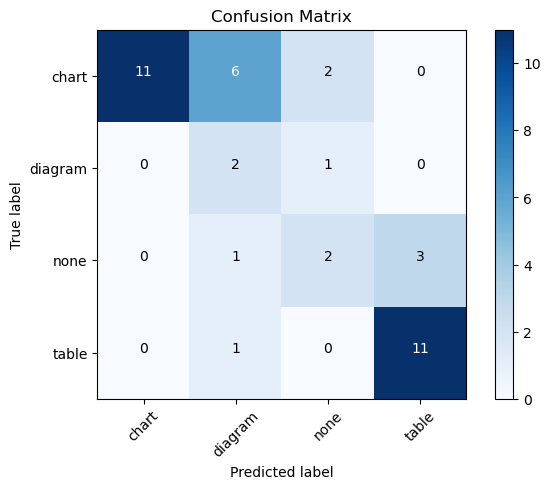

In [174]:
df = pd.read_csv('../../data/image_classification/output/넷플릭스주가_81_631.csv')
df['target'] = ['none','chart','table','none','none','none','none','table','diagram','chart','table','table','chart','chart','table',
                   'table','chart','table','chart','chart','table','diagram','diagram','table','chart','chart','chart','chart','table','table','table','chart','chart','chart','chart','chart','none','chart','chart','chart']
print(len(df[df['class']=='none'])/len(df))
display(df)
plot_confusion_matrix(cm=confusion_matrix(df['target'],df['class']), classes=CLASS_NAMES, title='Confusion Matrix')

0.3181818181818182


,filename,class,chart,diagram,none,table,target
0,image_거짓말탐지기_03_3_jpg,table,4.289915e-04,0.004307,0.046895,9.483690e-01,none
1,image_거짓말탐지기_05_2_jpg,none,4.588391e-02,0.130469,0.823647,3.833079e-12,none
2,image_거짓말탐지기_06_3_jpg,table,6.691673e-04,0.001147,0.014306,9.838784e-01,none
3,image_거짓말탐지기_12_4_jpg,table,6.198358e-03,0.024805,0.191601,7.773954e-01,none
4,image_거짓말탐지기_12_8_jpg,table,2.246306e-04,0.019535,0.058025,9.222154e-01,none
5,image_거짓말탐지기_13_7_jpg,none,2.345843e-03,0.042872,0.954783,1.240835e-08,none
6,image_거짓말탐지기_14_4_jpg,table,4.177798e-05,0.011230,0.142748,8.459804e-01,none
7,image_거짓말탐지기_16_4_jpg,table,1.748478e-02,0.148502,0.108197,7.258158e-01,table
8,image_거짓말탐지기_16_9_jpg,table,5.278259e-03,0.015552,0.090597,8.885729e-01,table
9,image_거짓말탐지기_17_12_jpg,table,2.517227e-03,0.043726,0.090590,8.631667e-01,none


class
table      13
none        7
diagram     2
Name: count, dtype: int64
Confusion matrix, without normalization
[[1 0 0]
 [0 7 9]
 [1 0 4]]


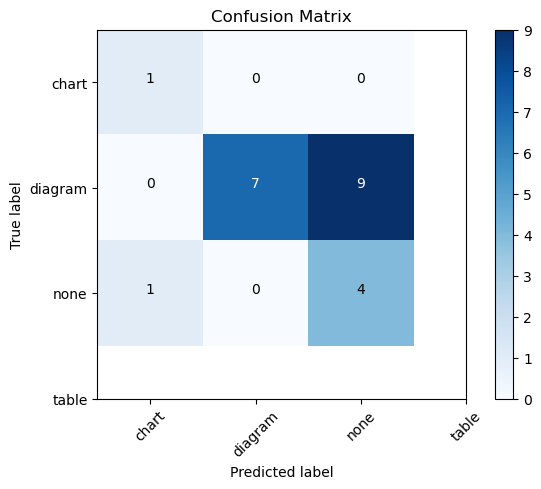

In [173]:
df = pd.read_csv('../../data/image_classification/output/거짓말탐지기_81_640.csv')
df['target'] = ['none','none','none','none','none','none','none','table','table','none','none','none','diagram','table','none','table','table','none','none','none','none','none']
print(len(df[df['class']=='none'])/len(df))
display(df)
print(df['class'].value_counts())
plot_confusion_matrix(cm=confusion_matrix(df['target'],df['class']), classes=CLASS_NAMES, title='Confusion Matrix')

0.34285714285714286


,filename,class,chart,diagram,none,table,target
0,image_웹툰추천_01_1_jpg,none,1.133950e-02,0.002414,0.986247,1.261424e-11,none
1,image_웹툰추천_01_5_jpg,none,1.550602e-01,0.029696,0.815244,2.476116e-10,none
2,image_웹툰추천_02_1_jpg,none,1.990984e-04,0.000225,0.999576,1.368132e-13,none
3,image_웹툰추천_03_6_jpg,none,9.082758e-05,0.230769,0.769140,9.953083e-08,none
4,image_웹툰추천_04_4_jpg,table,1.166461e-04,0.094036,0.129569,7.762779e-01,table
5,image_웹툰추천_04_5_jpg,table,5.469396e-08,0.000003,0.000032,9.999650e-01,table
6,image_웹툰추천_04_6_jpg,table,3.200113e-04,0.046842,0.043054,9.097838e-01,table
7,image_웹툰추천_05_4_jpg,table,2.368129e-03,0.066545,0.413800,5.172867e-01,none
8,image_웹툰추천_05_7_jpg,table,3.683480e-04,0.110169,0.150400,7.390620e-01,none
9,image_웹툰추천_05_8_jpg,none,4.556523e-03,0.232992,0.411249,3.512025e-01,table


class
table      18
none       12
diagram     5
Name: count, dtype: int64
Confusion matrix, without normalization
[[ 4  0  0]
 [ 0 11 11]
 [ 1  1  7]]


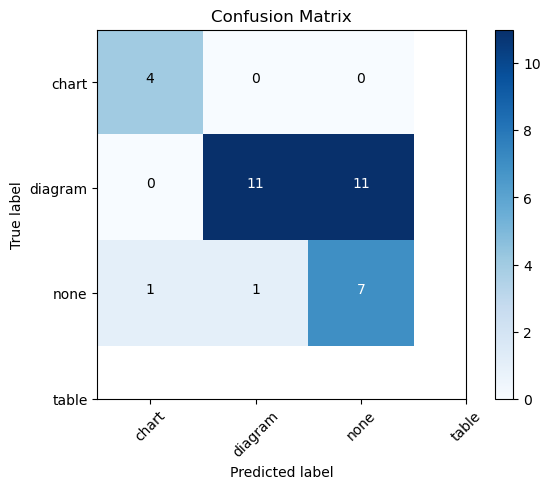

In [170]:
df = pd.read_csv('../../data/image_classification/output/웹툰추천_81_643.csv')
df['target'] = ['none','none','none','none','table','table','table','none','none','table','table','diagram','diagram','none','none','diagram','none','none','diagram','none','none','table','none','none','table','none','none','none','none','none','table','none','table','none','none']
print(len(df[df['class']=='none'])/len(df))
display(df)
print(df['class'].value_counts())
plot_confusion_matrix(cm=confusion_matrix(df['target'],df['class']), classes=CLASS_NAMES, title='Confusion Matrix')